In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.integrate import quad
import pandas as pd

In [4]:
np.set_printoptions(linewidth=150)
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [5]:
PT_drive = '/Users/ash/Library/CloudStorage/OneDrive-Nexus365/PHD/arunan/Martin_google_drive'

In [6]:
#csv combining sheets
df_helechos_18,df_helechos_19,df_helechos_20 = [pd.read_csv(f'{PT_drive}/Helechos_{year}.csv') for year in [18,19,20]]
combined = pd.concat([df_helechos_18,df_helechos_19,df_helechos_20], ignore_index=True, sort=False)
combined.columns = [str(c).strip() for c in combined.columns]
cols = ['Date', 'Month', 'Day', 'hour', 'Temp', 'RH%', 'Gastrotheca chysosticta', 'Oreobates berdemenos']
existing = [c for c in cols if c in combined.columns]
df_helechos = combined[existing].copy()
for col in ['Month', 'Day', 'hour', 'Gastrotheca chysosticta', 'Oreobates berdemenos']:
    if col in df_helechos.columns:
        df_helechos[col] = pd.to_numeric(df_helechos[col], errors='coerce').astype('Int64')


In [5]:
#Excel opening and combining sheets
df_helechos = pd.read_excel(f'{PT_drive}/Helechos_2018-2020.xlsx', sheet_name=None)
# Concatenate all sheets into a single DataFrame
combined = pd.concat(df_helechos.values(), ignore_index=True, sort=False)
combined.columns = [str(c).strip() for c in combined.columns]
cols = ['Date', 'Month', 'Day', 'hour', 'Temp', 'RH%', 'Gastrotheca chysosticta', 'Oreobates berdemenos']
existing = [c for c in cols if c in combined.columns]
df_helechos = combined[existing].copy()
# Cast selected columns to nullable integer dtype (preserves missing values)
for col in ['Month', 'Day', 'hour', 'Gastrotheca chysosticta', 'Oreobates berdemenos']:
    if col in df_helechos.columns:
        df_helechos[col] = pd.to_numeric(df_helechos[col], errors='coerce').astype('Int64')


In [7]:
print(df_helechos.iloc[1765:1769],'\n')
print(df_helechos.iloc[2158:2163],'\n')

            Date  Month  Day  hour    Temp     RH%  Gastrotheca chysosticta  Oreobates berdemenos
1765  14/11/2018     11  318    13  13.073  99.496                        0                     0
1766  14/11/2018     11  318    14  20.082  93.190                        0                     0
1767    11/14/18     11  318    15  14.038  89.570                        0                     0
1768    11/14/18     11  318    16  13.750  92.480                        0                     0 

            Date  Month  Day  hour    Temp    RH%  Gastrotheca chysosticta  Oreobates berdemenos
2158    11/30/18     11  334    22  16.618  100.0                        0                     0
2159    11/30/18     11  334    23  16.523  100.0                        0                     0
2160  12/01/2018     12  335     0  16.523  100.0                        0                     1
2161  12/01/2018     12  335     1  16.427  100.0                        0                     0
2162  12/01/2018     12

In [8]:
df_helechos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16799 entries, 0 to 16798
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     16798 non-null  object 
 1   Month                    16775 non-null  Int64  
 2   Day                      16775 non-null  Int64  
 3   hour                     16775 non-null  Int64  
 4   Temp                     13265 non-null  float64
 5   RH%                      11304 non-null  float64
 6   Gastrotheca chysosticta  13258 non-null  Int64  
 7   Oreobates berdemenos     13257 non-null  Int64  
dtypes: Int64(5), float64(2), object(1)
memory usage: 1.1+ MB


In [147]:
import re

# Standardise Date strings: if pattern is xx/xx/xxxx keep only last two year chars -> xx/xx/xx

def _shorten_year(seg: str) -> str:
    # Handles a segment that may contain trailing time (e.g., '2020 00:00:00')
    if ' ' in seg:
        year_part, rest = seg.split(' ', 1)
    else:
        year_part, rest = seg, ''
    if len(year_part) == 4:  # exactly four chars -> drop first two
        new_year = year_part[-2:]
        return new_year + (' ' + rest if rest else '')
    return seg  # leave unchanged

def shorten_date_value(v):
    if pd.isna(v):
        return v
    if isinstance(v, pd.Timestamp):
        return v  # already datetime-like, leave for later parsing
    s = str(v).strip()
    # Only process strings with exactly two '/'
    if s.count('/') == 2:
        a, b, c = s.split('/')
        c_new = _shorten_year(c)
        s_new = f"{a}/{b}/{c_new}"
        return s_new
    return s

if 'Date' in df_helechos.columns:
    df_helechos['Date'] = df_helechos['Date'].apply(shorten_date_value)

In [9]:
# date changes from dd/mm to mm/dd at row 1767

print(df_helechos.iloc[1765:1769],'\n')
df_dd_mm = df_helechos.iloc[:1767].copy()
df_mm_dd = df_helechos.iloc[1767:].copy()
print(df_dd_mm.tail(),'\n')
print(df_mm_dd.head(),'\n')
df_dd_mm['Date'] = pd.to_datetime(df_dd_mm['Date'], format='%d/%m/%Y', errors='coerce')
date_raw = df_mm_dd['Date'].astype(str).str.strip()
parsed = pd.to_datetime(date_raw, format='%m/%d/%Y', errors='coerce')
mask = parsed.isna()
if mask.any():
    parsed_alt = pd.to_datetime(date_raw[mask], format='%m/%d/%y', errors='coerce')
    parsed[mask] = parsed_alt
df_mm_dd['Date'] = parsed
df_helechos_2018_2020 = pd.concat([df_dd_mm, df_mm_dd], ignore_index=True)
print(df_helechos_2018_2020.iloc[1765:1769])


            Date  Month  Day  hour    Temp     RH%  Gastrotheca chysosticta  Oreobates berdemenos
1765  14/11/2018     11  318    13  13.073  99.496                        0                     0
1766  14/11/2018     11  318    14  20.082  93.190                        0                     0
1767    11/14/18     11  318    15  14.038  89.570                        0                     0
1768    11/14/18     11  318    16  13.750  92.480                        0                     0 

            Date  Month  Day  hour    Temp      RH%  Gastrotheca chysosticta  Oreobates berdemenos
1762  14/11/2018     11  318    10  12.572  100.000                        0                     0
1763  14/11/2018     11  318    11  12.071  100.000                        0                     0
1764  14/11/2018     11  318    12  12.572  100.000                        0                     0
1765  14/11/2018     11  318    13  13.073   99.496                        0                     0
1766  14/11/2

In [15]:
print(df_helechos_2018_2020.iloc[2158:2163],'\n')

           Date  Month  Day  hour    Temp    RH%  Gastrotheca chysosticta  Oreobates berdemenos
2158 2018-11-30     11  334    22  16.618  100.0                        0                     0
2159 2018-11-30     11  334    23  16.523  100.0                        0                     0
2160 2018-12-01     12  335     0  16.523  100.0                        0                     1
2161 2018-12-01     12  335     1  16.427  100.0                        0                     0
2162 2018-12-01     12  335     2  16.237  100.0                        0                     0 



In [10]:

# remove records where there is no annotation
df_helechos_2018_2020 = df_helechos_2018_2020[df_helechos_2018_2020['Gastrotheca chysosticta'].notna() | df_helechos_2018_2020['Oreobates berdemenos'].notna()]
# df_helechos_2018_2020 = df_helechos_2018_2020[df_helechos_2018_2020['Oreobates berdemenos'].notna()]

In [11]:
# Find records with missing (NaN / <NA>) values in 'Oreobates berdemenos'
oreobates_nan = df_helechos_2018_2020[df_helechos_2018_2020['Oreobates berdemenos'].isna()]
# Drop rows with missing 'Oreobates berdemenos' and recompute
print(oreobates_nan)
if len(oreobates_nan) > 0:
    df_helechos_2018_2020 = df_helechos_2018_2020.drop(oreobates_nan.index)
    oreobates_nan = df_helechos_2018_2020[df_helechos_2018_2020['Oreobates berdemenos'].isna()]
print(f"Number of records with NaN in 'Oreobates berdemenos': {len(oreobates_nan)}")

           Date  Month  Day  hour    Temp    RH%  Gastrotheca chysosticta  Oreobates berdemenos
1128 2018-10-19     10  292     0  21.583  81.86                        0                  <NA>
Number of records with NaN in 'Oreobates berdemenos': 0


In [12]:
# Count records where species are present
berdemenos_count = (df_helechos_2018_2020['Oreobates berdemenos'] > 0).sum()
chysosticta_count = sum(df_helechos_2018_2020['Gastrotheca chysosticta'] > 0)

# Count records where both species are present together
both_species_count = sum((df_helechos_2018_2020['Oreobates berdemenos'] > 0) & 
                         (df_helechos_2018_2020['Gastrotheca chysosticta'] > 0))

# Find dates where both species are present
both_species_present = df_helechos_2018_2020.groupby('Date').filter(
    lambda x: (x['Oreobates berdemenos'] > 0).any() and (x['Gastrotheca chysosticta'] > 0).any()
)['Date'].unique()

# Print results
print(f"Records with Oreobates berdemenos present: {berdemenos_count}")
print(f"Records with Gastrotheca chysosticta present: {chysosticta_count}")
print(f"Records with both species present together: {both_species_count}")
print(f"Number of unique dates with both species present: {len(both_species_present)}")

# Calculate percentage of co-occurrence relative to each species
if berdemenos_count > 0:
    print(f"Percentage of O. berdemenos records with G. chysosticta present: {both_species_count/berdemenos_count*100:.2f}%")
if chysosticta_count > 0:
    print(f"Percentage of G. chysosticta records with O. berdemenos present: {both_species_count/chysosticta_count*100:.2f}%")

Records with Oreobates berdemenos present: 784
Records with Gastrotheca chysosticta present: 1149
Records with both species present together: 100
Number of unique dates with both species present: 60
Percentage of O. berdemenos records with G. chysosticta present: 12.76%
Percentage of G. chysosticta records with O. berdemenos present: 8.70%


In [13]:
# Sort the DataFrame by date
df_helechos_2018_2020 = df_helechos_2018_2020.sort_values(by='Date', ascending=True)

# Display the first few rows to verify sorting
print("DataFrame sorted by date:")
print(df_helechos_2018_2020.head())

DataFrame sorted by date:
         Date  Month  Day  hour   Temp      RH%  Gastrotheca chysosticta  Oreobates berdemenos
0  2018-09-02      9  245     0  4.553  100.000                        0                     0
23 2018-09-02      9  245    23  7.561   86.595                        1                     0
22 2018-09-02      9  245    22  7.561   88.655                        0                     0
21 2018-09-02      9  245    21  8.564   86.076                        0                     0
20 2018-09-02      9  245    20  9.566   82.924                        1                     0


In [26]:
df_helechos_2018_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13257 entries, 0 to 16486
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     13257 non-null  datetime64[ns]
 1   Month                    13257 non-null  Int64         
 2   Day                      13257 non-null  Int64         
 3   hour                     13257 non-null  Int64         
 4   Temp                     13257 non-null  float64       
 5   RH%                      11303 non-null  float64       
 6   Gastrotheca chysosticta  13257 non-null  Int64         
 7   Oreobates berdemenos     13257 non-null  Int64         
dtypes: Int64(5), datetime64[ns](1), float64(2)
memory usage: 996.9 KB


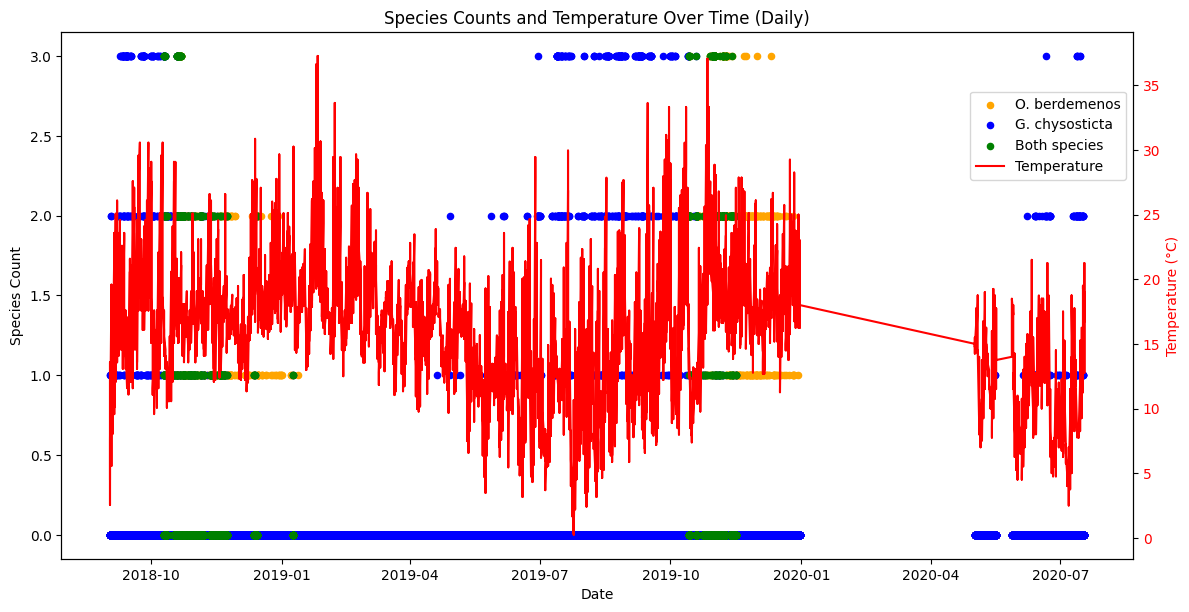

In [14]:
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot species counts on primary y-axis
ax1.scatter(df_helechos_2018_2020['Date'], df_helechos_2018_2020['Oreobates berdemenos'], color='orange', label='O. berdemenos', s=20, zorder=1)
ax1.scatter(df_helechos_2018_2020['Date'], df_helechos_2018_2020['Gastrotheca chysosticta'], color='blue', label='G. chysosticta', s=20, zorder=2)


# Plot green points for dates where both species are present
if len(both_species_present) > 0:
    for i, date in enumerate(both_species_present):
        filtered_data = df_helechos_2018_2020[df_helechos_2018_2020['Date']==date]
        y_values = filtered_data['Oreobates berdemenos']
        x_values = [date] * len(y_values)  # Repeat date for each y value
        #only add label for first instance to stop legend having millions of entries
        label = 'Both species' if i == 0 else ""
        ax1.scatter(x_values, y_values, color='green', s=20, label=label, zorder=3)
        ax1.scatter(x_values, filtered_data['Gastrotheca chysosticta'], color='green', s=20, label='', zorder=3)


ax1.set_xlabel('Date')
ax1.set_ylabel('Species Count', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Limit to last 6 months for better visualization
# date_max = df_helechos_2018_2020['Date'].max() - pd.DateOffset(months=2)
# date_min = df_helechos_2018_2020['Date'].max() - pd.DateOffset(months=3)
# plt.xlim(date_min, date_max)

# Create secondary y-axis for temperature
ax2 = ax1.twinx()
ax2.plot(df_helechos_2018_2020['Date'], df_helechos_2018_2020['Temp'], 'r-', label='Temperature')
ax2.set_ylabel('Temperature (°C)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right',bbox_to_anchor = (1,0.9))

# Improve date formatting on x-axis
plt.xticks(rotation=45)
fig.tight_layout()

plt.title('Species Counts and Temperature Over Time (Daily)')
plt.show()

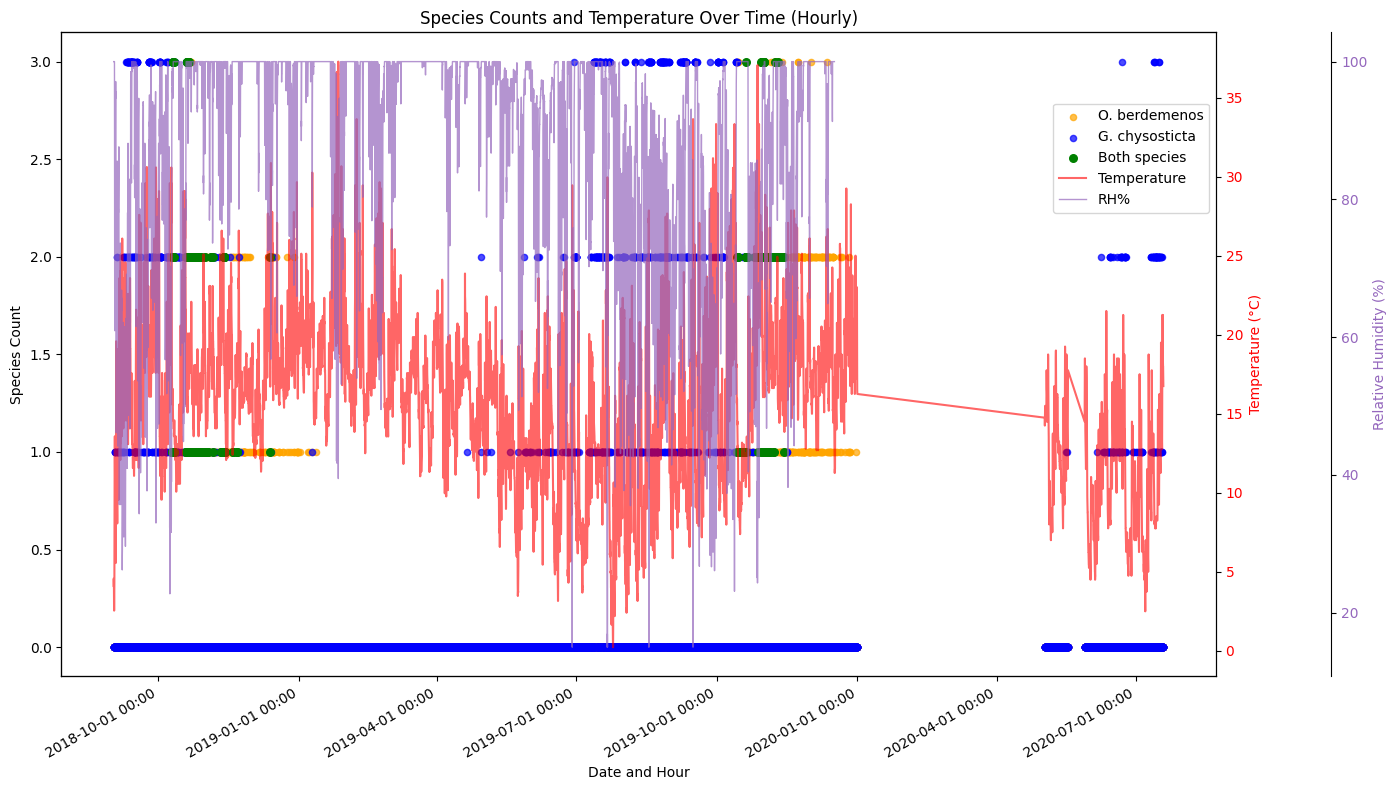

In [17]:
# Convert 'Date' and 'hour' to a combined datetime for x-axis
df_helechos_2018_2020['DateTime'] = pd.to_datetime(df_helechos_2018_2020['Date']) + pd.to_timedelta(df_helechos_2018_2020['hour'], unit='h')
# Sort DataFrame by DateTime to ensure proper chronological ordering
df_helechos_2018_2020 = df_helechos_2018_2020.sort_values(by='DateTime')
# Create figure and primary axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot species counts on primary y-axis
ax1.scatter(df_helechos_2018_2020['DateTime'], df_helechos_2018_2020['Oreobates berdemenos'], 
            color='orange', label='O. berdemenos', s=20, alpha=0.7, zorder=1)
ax1.scatter(df_helechos_2018_2020['DateTime'], df_helechos_2018_2020['Gastrotheca chysosticta'], 
            color='blue', label='G. chysosticta', s=20, alpha=0.7, zorder=2)

# Find times where both species are present in the same hour
both_species_hourly = df_helechos_2018_2020[
    (df_helechos_2018_2020['Oreobates berdemenos'] > 0) & 
    (df_helechos_2018_2020['Gastrotheca chysosticta'] > 0)
]

# Plot green points for hours where both species are present
if len(both_species_hourly) > 0:
    ax1.scatter(both_species_hourly['DateTime'], both_species_hourly['Oreobates berdemenos'], 
                color='green', s=30, label='Both species', zorder=4)
    ax1.scatter(both_species_hourly['DateTime'], both_species_hourly['Gastrotheca chysosticta'], 
                color='green', s=30, label='', zorder=5)
    

ax1.set_xlabel('Date and Hour')
ax1.set_ylabel('Species Count', color='k')
ax1.tick_params(axis='y', labelcolor='k')

# Create secondary y-axis for temperature
ax2 = ax1.twinx()
ax2.plot(df_helechos_2018_2020['DateTime'], df_helechos_2018_2020['Temp'], 'r-', linewidth=1.5, alpha=0.6, label='Temperature')
ax2.set_ylabel('Temperature (°C)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
# Third axis for RH%
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('axes', 1.10))
ax3.set_ylabel('Relative Humidity (%)', color='tab:purple')
ax3.tick_params(axis='y', labelcolor='tab:purple')
ax3.plot(df_helechos_2018_2020['DateTime'],
         df_helechos_2018_2020['RH%'],
         color='tab:purple', linestyle='-', linewidth=1, alpha=0.7, label='RH%',zorder=3)

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()
ax3.legend(lines1 + lines2 +lines3, labels1 + labels2+labels3, loc='upper right',bbox_to_anchor = (1,0.9))

# # Limit to a shorter time window for better visualization with hourly data
# date_max = df_helechos_2018_2020['DateTime'].max() - pd.Timedelta(days=515)#
# date_min = df_helechos_2018_2020['DateTime'].max() - pd.Timedelta(days=520)#, 81 has lots of noise
# plt.xlim(date_min, date_max)

# Improve date formatting on x-axis
plt.gcf().autofmt_xdate()
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.xticks(rotation=45)

plt.title('Species Counts and Temperature Over Time (Hourly)')
plt.tight_layout()
plt.show()

In [29]:
df_helechos_2018_2020.head()

,Date,Month,Day,hour,Temp,RH%,Gastrotheca chysosticta,Oreobates berdemenos,DateTime
0,2018-09-02,9,245,0,4.553,100.0,0,0,2018-09-02 00:00:00
1,2018-09-02,9,245,1,4.051,100.0,0,0,2018-09-02 01:00:00
2,2018-09-02,9,245,2,4.553,100.0,0,0,2018-09-02 02:00:00
3,2018-09-02,9,245,3,3.550,100.0,0,0,2018-09-02 03:00:00
4,2018-09-02,9,245,4,3.048,100.0,0,0,2018-09-02 04:00:00


In [16]:
# Group records by DateTime and count the occurrences
datetime_counts = df_helechos_2018_2020.groupby('DateTime').size().reset_index(name='count')

# Show the distribution of counts
print(f"Total number of unique DateTimes: {len(datetime_counts)}")
print(f"DateTimes with multiple records: {sum(datetime_counts['count'] > 1)}")
print("\nDistribution of records per DateTime:")
print(datetime_counts['count'].value_counts().sort_index())

# Identify the DateTimes with the most records
print("\nDateTimes with the most records:")
most_records = datetime_counts.sort_values(by='count', ascending=False).head(5)
print(most_records)

# Show examples of duplicate DateTimes
if sum(datetime_counts['count'] > 1) > 0:
    print("\nExample of records with the same DateTime:")
    duplicate_datetime = datetime_counts[datetime_counts['count'] > 1]['DateTime'].iloc[0]
    print(df_helechos_2018_2020[df_helechos_2018_2020['DateTime'] == duplicate_datetime])

KeyError: 'DateTime'

In [31]:
print(df_helechos_2018_2020.head())
df_helechos_2018_2020.tail(15)

        Date  Month  Day  hour   Temp    RH%  Gastrotheca chysosticta  Oreobates berdemenos            DateTime
0 2018-09-02      9  245     0  4.553  100.0                        0                     0 2018-09-02 00:00:00
1 2018-09-02      9  245     1  4.051  100.0                        0                     0 2018-09-02 01:00:00
2 2018-09-02      9  245     2  4.553  100.0                        0                     0 2018-09-02 02:00:00
3 2018-09-02      9  245     3  3.550  100.0                        0                     0 2018-09-02 03:00:00
4 2018-09-02      9  245     4  3.048  100.0                        0                     0 2018-09-02 04:00:00


,Date,Month,Day,hour,Temp,RH%,Gastrotheca chysosticta,Oreobates berdemenos,DateTime
16472,2020-07-18,7,200,9,21.25,NaN,0,0,2020-07-18 09:00:00
16473,2020-07-18,7,200,10,21.25,NaN,0,0,2020-07-18 10:00:00
16474,2020-07-18,7,200,11,21.00,NaN,0,0,2020-07-18 11:00:00
16475,2020-07-18,7,200,12,21.25,NaN,0,0,2020-07-18 12:00:00
16476,2020-07-18,7,200,13,19.00,NaN,0,0,2020-07-18 13:00:00
16477,2020-07-18,7,200,14,18.75,NaN,0,0,2020-07-18 14:00:00
16478,2020-07-18,7,200,15,18.50,NaN,0,0,2020-07-18 15:00:00
16479,2020-07-18,7,200,16,18.50,NaN,0,0,2020-07-18 16:00:00
16480,2020-07-18,7,200,17,18.25,NaN,0,0,2020-07-18 17:00:00
16481,2020-07-18,7,200,18,18.00,NaN,0,0,2020-07-18 18:00:00


# clean all columns, either interpolate or remove records without full data

In [42]:
# Missing (invalid) entry counts per column for df_helechos_2018_2020
missing_counts = df_helechos_2018_2020.isna().sum()
missing_summary = (
    missing_counts.to_frame(name='missing')
    .assign(total=len(df_helechos_2018_2020),
            percent=lambda d: d['missing'] / d['total'] * 100)
)

print("Missing value summary (NaN / <NA>):")
print(missing_summary)

# If you also want rows that have any missing field:
rows_with_any_missing = df_helechos_2018_2020.isna().any(axis=1).sum()
print(f"\nRows with at least one missing value: {rows_with_any_missing} "
      f"({rows_with_any_missing/len(df_helechos_2018_2020)*100:.2f}%)")

Missing value summary (NaN / <NA>):
                         missing  total    percent
Date                           0  13257   0.000000
Month                          0  13257   0.000000
Day                            0  13257   0.000000
hour                           0  13257   0.000000
Temp                           0  13257   0.000000
RH%                         1954  13257  14.739383
Gastrotheca chysosticta        0  13257   0.000000
Oreobates berdemenos           0  13257   0.000000
DateTime                       0  13257   0.000000

Rows with at least one missing value: 1954 (14.74%)


In [43]:
# Remove rows with missing RH%
before = len(df_helechos_2018_2020)
df_helechos_2018_2020 = df_helechos_2018_2020[df_helechos_2018_2020['RH%'].notna()].copy()
after = len(df_helechos_2018_2020)
print(f"Removed {before - after} rows with missing RH%. Remaining rows: {after}")

Removed 1954 rows with missing RH%. Remaining rows: 11303


In [52]:
df_helechos_2018_2020.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11303 entries, 0 to 11303
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     11303 non-null  datetime64[ns]
 1   Month                    11303 non-null  Int64         
 2   Day                      11303 non-null  Int64         
 3   hour                     11303 non-null  Int64         
 4   Temp                     11303 non-null  float64       
 5   RH%                      11303 non-null  float64       
 6   Gastrotheca chysosticta  11303 non-null  Int64         
 7   Oreobates berdemenos     11303 non-null  Int64         
 8   DateTime                 11303 non-null  datetime64[ns]
dtypes: Int64(5), datetime64[ns](2), float64(2)
memory usage: 938.2 KB


In [72]:
from statsmodels.genmod.cov_struct import Exchangeable

# GLMM-style analysis of call counts for the two species using Poisson (and NB if overdispersed)
# We approximate a Poisson GLMM with a GEE (clustered by day) and also fit a Gaussian mixed model on log(count+1).

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Prepare long-format data
species_cols = ['Oreobates berdemenos', 'Gastrotheca chysosticta']
needed = ['DateTime', 'hour', 'Temp', 'RH%'] + species_cols
df_glmm = df_helechos_2018_2020[needed].dropna().copy()

# Rename RH% to RH for formula compatibility
df_glmm = df_glmm.rename(columns={'RH%': 'RH'})

# Melt to long format
df_long = df_glmm.melt(
    id_vars=['DateTime', 'hour', 'Temp', 'RH'],
    value_vars=species_cols,
    var_name='species',
    value_name='count'
)

# Drop rows where count is missing
df_long = df_long.dropna(subset=['count'])

# Add day (grouping factor) for random intercept approximation
df_long['day'] = df_long['DateTime'].dt.floor('D')

# Basic descriptors
mean_var = (
    df_long.groupby('species')['count']
    .agg(['mean', 'var'])
    .assign(var_over_mean=lambda d: d['var'] / d['mean'].where(d['mean'] > 0))
)
print("Mean/Var by species:\n", mean_var, "\n")

# Poisson GEE (cluster on day, exchangeable working correlation)
formula = 'count ~ species + Temp + RH + species:Temp + species:RH'
gee_pois = smf.gee(
    formula=formula,
    groups='day',
    data=df_long,
    family=sm.families.Poisson(),
    cov_struct=Exchangeable()
).fit()
print("\n=== Poisson GEE (cluster=day) ===")
print(gee_pois.summary())

# Check overdispersion (scale > 1 suggests overdispersion)
print(f"\nPoisson GEE scale (overdispersion factor): {gee_pois.scale:.3f}")

# If overdispersed, fit Negative Binomial GEE
if gee_pois.scale > 1.5:
    gee_nb = smf.gee(
        formula=formula,
        groups='day',
        data=df_long,
        family=sm.families.NegativeBinomial(),  # variance = mu + alpha*mu^2
        cov_struct=Exchangeable()
    ).fit()
    print("\n=== Negative Binomial GEE (cluster=day) ===")
    print(gee_nb.summary())

# Gaussian Mixed Model on log(count+1) as a rough alternative
df_long['log_count1'] = np.log1p(df_long['count'])
mixed_formula = 'log_count1 ~ species + Temp + RH + species:Temp + species:RH'
mixed = smf.mixedlm(mixed_formula, data=df_long, groups=df_long['day']).fit(method='lbfgs')
print("\n=== Gaussian MixedLM on log(count+1) (random intercept: day) ===")
print(mixed.summary())

# Quick interpretation helper
print("\nNotes:")
print("- Poisson/NB GEE gives population-averaged (marginal) effects with day-level clustering.")
print("- MixedLM uses log(count+1) Gaussian approximation with a random intercept for day.")
print("- Interaction terms (species:Temp, species:RH) show differential environmental effects between species.")

Mean/Var by species:
                              mean       var  var_over_mean
species                                                   
Gastrotheca chysosticta  0.168539  0.342411        2.03164
Oreobates berdemenos     0.116783  0.216054       1.850047 


=== Poisson GEE (cluster=day) ===
                               GEE Regression Results                              
Dep. Variable:                       count   No. Observations:                22606
Model:                                 GEE   No. clusters:                      471
Method:                        Generalized   Min. cluster size:                  46
                      Estimating Equations   Max. cluster size:                  48
Family:                            Poisson   Mean cluster size:                48.0
Dependence structure:         Exchangeable   Num. iterations:                    30
Date:                     Thu, 11 Sep 2025   Scale:                           1.000
Covariance type:                 

/Users/ash/Library/CloudStorage/OneDrive-Nexus365/PHD/arunan/untitled folder/yungas_aruna/.venv/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)



=== Gaussian MixedLM on log(count+1) (random intercept: day) ===
                     Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         log_count1
No. Observations:         22606           Method:                     REML      
No. Groups:               471             Scale:                      0.0644    
Min. group size:          46              Log-Likelihood:             -1661.3831
Max. group size:          48              Converged:                  Yes       
Mean group size:          48.0                                                  
--------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                             0.227    0.036   6.243 0.000  0.156  0.299
species[T.Oreobates berdemenos]      -0.611    0.027 -22.257 0.00

# Granger Causality

In [74]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd

# Granger / VAR causality test between the two species time series


# 1. Prepare evenly spaced hourly series (sum per hour), fill missing with 0
cols = ['Oreobates berdemenos', 'Gastrotheca chysosticta']
df_gc = (
    df_helechos_2018_2020[['DateTime'] + cols]
    .dropna(subset=['DateTime'])
    .sort_values('DateTime')
    .set_index('DateTime')
    .resample('H')
    .sum()
    .fillna(0)
)

# 2. ADF stationarity test; difference if non–stationary (p>0.05)
def adf_stationary(series, name):
    s = series.astype(float)
    if (s.var() == 0) or (s.nunique() < 3):
        return s, False, 1.0
    p = adfuller(s, autolag='AIC')[1]
    return s, True, p

stationary_series = {}
diff_needed = {}
adf_pvals = {}
for c in cols:
    s, ok, p = adf_stationary(df_gc[c], c)
    adf_pvals[c] = p
    if p > 0.05:
        # first difference
        s_diff = s.diff().dropna()
        # Re-test (optional, not required for workflow)
        stationary_series[c] = s_diff
        diff_needed[c] = True
    else:
        stationary_series[c] = s
        diff_needed[c] = False

# Align after differencing (drop NaNs introduced by differencing)
gc_data = pd.concat(stationary_series, axis=1).dropna()

# Ensure enough data
if len(gc_data) < 30:
    raise ValueError("Not enough data after preprocessing for VAR/Granger test.")

# 3. Select VAR lag order (up to 24 hours or len/5)
maxlags = min(24, max(5, len(gc_data)//5))
order_res = VAR(gc_data).select_order(maxlags=maxlags)
lag_aic = order_res.selected_orders.get('aic')
# fallback if None
selected_lag = lag_aic if lag_aic is not None else next(v for v in order_res.selected_orders.values() if v is not None)

# Guard: lag must be >=1
if not selected_lag or selected_lag < 1:
    selected_lag = 1

# 4. Fit VAR
model = VAR(gc_data)
var_res = model.fit(selected_lag)

# 5. Causality tests (directional)
# Test: does Oreobates -> Gastrotheca?
res_OB_to_GC = var_res.test_causality('Gastrotheca chysosticta', ['Oreobates berdemenos'], kind='f')

# Test: does Gastrotheca -> Oreobates?
res_GC_to_OB = var_res.test_causality('Oreobates berdemenos', ['Gastrotheca chysosticta'], kind='f')

print("=== Data summary ===")
print(f"Rows (hourly, after differencing if applied): {len(gc_data)}")
print("ADF p-values (original series):")
for c in cols:
    print(f"  {c}: p={adf_pvals[c]:.4g}  -> differenced: {diff_needed[c]}")
print(f"\nSelected VAR lag (AIC): {selected_lag}")
print("\n=== Direction: Oreobates berdemenos -> Gastrotheca chysosticta ===")
print(f"F-test p-value: {res_OB_to_GC.pvalue:.4g}")
print(res_OB_to_GC.summary())

print("\n=== Direction: Gastrotheca chysosticta -> Oreobates berdemenos ===")
print(f"F-test p-value: {res_GC_to_OB.pvalue:.4g}")
print(res_GC_to_OB.summary())

print("\nInterpretation guide:")
print("- Low p-value (<0.05) suggests rejecting null of 'no Granger causality' in that direction.")
print("- Differencing applied where ADF indicated non-stationarity (p>0.05).")
print("- Results are on (possibly differenced) series; ecological interpretation should map back to original counts.")

/var/folders/fv/6lp893hd21qcv8d6dcgrwb4w0000gp/T/ipykernel_3713/2190148300.py:16: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('H')


=== Data summary ===
Rows (hourly, after differencing if applied): 11304
ADF p-values (original series):
  Oreobates berdemenos: p=4.555e-12  -> differenced: False
  Gastrotheca chysosticta: p=1.241e-15  -> differenced: False

Selected VAR lag (AIC): 24

=== Direction: Oreobates berdemenos -> Gastrotheca chysosticta ===
F-test p-value: 0.2985
Granger causality F-test. H_0: Oreobates berdemenos does not Granger-cause Gastrotheca chysosticta. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value           df         
-----------------------------------------------------------
         1.130          1.518   0.298 (24, np.int64(22462))
-----------------------------------------------------------

=== Direction: Gastrotheca chysosticta -> Oreobates berdemenos ===
F-test p-value: 0.02878
Granger causality F-test. H_0: Gastrotheca chysosticta does not Granger-cause Oreobates berdemenos. Conclusion: reject H_0 at 5% significance level.
Test statistic Cr

## Treat calls as ordinal, add weather, hour, day as exogenous variables

In [23]:
# Ordered-logit "Granger" causality with exogenous controls (temp, RH, diurnal)
# Directional tests: Oreo -> Gastro and Gastro -> Oreo

import numpy as np
import pandas as pd
from itertools import product
from typing import Tuple, Dict, List
import warnings

from statsmodels.miscmodels.ordinal_model import OrderedModel
from scipy.stats import chi2


# ----------------------------
# Utilities
# ----------------------------

def add_time_features(dfh: pd.DataFrame) -> pd.DataFrame:
    """Add diurnal sin/cos based on the DateTimeIndex (hour + minute)."""
    h = dfh.index.hour + dfh.index.minute / 60.0
    day = dfh.index.dayofyear + h / 24.0
    dfh = dfh.copy()
    dfh["hour_sin"] = np.sin(2 * np.pi * h / 24.0)
    dfh["hour_cos"] = np.cos(2 * np.pi * h / 24.0)
    dfh['day_sin'] = np.sin(2 * np.pi * day / 365.25)
    dfh['day_cos'] = np.cos(2 * np.pi * day / 365.25)
    return dfh

def zscore(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    '''Normalize specified columns to mean 0, std 1; add as col_z.'''
    df = df.copy()
    for c in cols:
        mu, sd = df[c].mean(), df[c].std()
        if not np.isfinite(sd) or sd == 0:
            sd = 1.0
        df[c + "_z"] = (df[c] - mu) / sd
    return df

def make_lags(df: pd.DataFrame, cols: List[str], L: int) -> pd.DataFrame:
    """Create lagged columns col_L1..col_LL for each col."""
    out = {}
    for c in cols:
        for l in range(1, L + 1):
            out[f"{c}_L{l}"] = df[c].shift(l)
    return pd.DataFrame(out, index=df.index)

def aic_of_fit(res) -> float:
    """Compute AIC for OrderedModel fit result."""
    k = len(res.params)
    return -2 * res.llf + 2 * k

def fit_ordered(endog: pd.Series, exog: pd.DataFrame, distr: str = "logit"):
    """
    Fit ordered logit/probit without an explicit constant (thresholds play that role).
    endog must be integer categories (0..K-1).
    """
    # Drop any rows with missing exog (endog should already be aligned)
    mask = endog.notna()
    mask &= exog.notna().all(axis=1)
    y = endog[mask].astype(int)
    X = exog.loc[mask]

    # Quick rank check to catch collinearity early (optional)
    rank = np.linalg.matrix_rank(X.values)
    if rank < X.shape[1]:
        raise ValueError(f"Design matrix not full rank (rank={rank} < {X.shape[1]}). "
                         f"Reduce lags / remove redundant columns (do not lag sin/cos).")

    model = OrderedModel(y, X, distr=distr)
    # Increase maxiter if needed; method can be 'bfgs'/'lbfgs'/'newton'
    res = model.fit(method="lbfgs", maxiter=2000, disp=False)
    return res, y.index

def lr_test(res_full, res_rest, df_restr: int) -> Tuple[float, float]:
    """LR stat and chi-square p-value."""
    LR = 2 * (res_full.llf - res_rest.llf)
    p = 1 - chi2.cdf(LR, df_restr)
    return LR, p



In [25]:

# ----------------------------
# Main: Ordinal Granger tester
# ----------------------------

def ordinal_granger_with_exog(
    df_hourly: pd.DataFrame,
    gastro_col: str,
    oreo_col: str,
    temp_col: str,
    rh_col: str,
    max_p: int = 24,          # candidate max call lags to search over
    s_exog: int = 6,          # weather lag span (0..s_exog)
    include_hour: bool = True,
    distr: str = "logit",     # "logit" or "probit"
    p_fixed: int | None = None,   # set an explicit p, else AIC-select
) -> Dict:
    """
    Perform directional ordinal Granger tests with exogenous controls:
    - Oreo -> Gastro (conditional on Gastro lags, temp/RH, diurnal)
    - Gastro -> Oreo (conditional on Oreo lags, temp/RH, diurnal)
    """

    # 1) Prepare base frame (assumes hourly DateTimeIndex)
    req = [gastro_col, oreo_col, temp_col, rh_col]
    data = df_hourly.sort_index()[req].copy()

    # Ensure integer categories 0..3 for calls
    for c in (gastro_col, oreo_col):
        data[c] = data[c].astype(int)

    # Add diurnal & standardized weather
    data = add_time_features(data) if include_hour else data.assign(hour_sin=0.0, hour_cos=0.0)
    data = zscore(data, [temp_col, rh_col])

    # Build EXOG: current sin/cos + weather lags only
    EXOG_parts = [data[["hour_sin", "hour_cos",'day_sin','day_cos']]]
    for base in [temp_col + "_z", rh_col + "_z"]:
        cols = {f"{base}_L0": data[base]}
        for L in range(1, s_exog + 1):
            cols[f"{base}_L{L}"] = data[base].shift(L)
        EXOG_parts.append(pd.DataFrame(cols, index=data.index))
    EXOG = pd.concat(EXOG_parts, axis=1)

    print(EXOG.head())
    
    # Helper to fit a direction (X -> Y)
    def fit_direction(Y_name: str, X_name: str, p_choice: int | None):
        # If p not fixed, select by AIC over 1..max_p on the FULL model
        p_grid = [p_choice] if p_choice else list(range(1, max_p + 1))
        best = {"aic": np.inf, "p": None, "res_full": None, "res_rest": None, "used_idx": None}

        for p in p_grid:
            # Build lag matrices
            own_lags = make_lags(data, [Y_name], p)
            cross_lags = make_lags(data, [X_name], p)

            # Full design = own lags + cross lags + exogenous
            X_full = pd.concat([own_lags, cross_lags, EXOG], axis=1)

            # Restricted design = drop cross lags
            X_rest = pd.concat([own_lags, EXOG], axis=1)

            # Align endog/exog and drop NA from lagging
            endog = data[Y_name]

            # Fit both models on the same aligned index (intersection of non-NA rows)
            fit_full, idx_full = fit_ordered(endog, X_full, distr=distr)
            fit_rest, idx_rest = fit_ordered(endog, X_rest.loc[idx_full], distr=distr)  # fit on idx_full

            # Compute AIC for the FULL model
            aic = aic_of_fit(fit_full)

            if aic < best["aic"]:
                best.update({
                    "aic": aic,
                    "p": p,
                    "res_full": fit_full,
                    "res_rest": fit_rest,
                    "used_idx": idx_full,
                    "q": p,  # number of cross-lag restrictions when lags enter linearly
                })

        # LR test on the chosen p
        LR, pval = lr_test(best["res_full"], best["res_rest"], best["q"])
        return {
            "direction": f"{X_name} → {Y_name}",
            "selected_p": best["p"],
            "LR": float(LR),
            "df": int(best["q"]),
            "p_value": float(pval),
            "aic_full": float(aic_of_fit(best["res_full"])),
            "n_obs": int(len(best["used_idx"])),
            "full_params": best["res_full"].params,   # includes thresholds and coefficients
            "rest_params": best["res_rest"].params,
        }

    # Run both directions
    res_Oreo_to_Gastro = fit_direction(Y_name=gastro_col, X_name=oreo_col, p_choice=p_fixed)
    res_Gastro_to_Oreo = fit_direction(Y_name=oreo_col, X_name=gastro_col, p_choice=p_fixed)

    return {
        "settings": {
            "p_fixed": p_fixed,
            "max_p_grid": max_p if p_fixed is None else None,
            "weather_lag_span": s_exog,
            "include_hour": include_hour,
            "link": distr
        },
        "Oreo_to_Gastro": res_Oreo_to_Gastro,
        "Gastro_to_Oreo": res_Gastro_to_Oreo
    }



In [26]:
df = pd.read_csv(f'{PT_drive}/df_helechos_clean.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df = df.set_index('DateTime').sort_index()
df.head()

,Date,Month,Day,hour,Temp,RH%,Gastrotheca chysosticta,Oreobates berdemenos
DateTime,,,,,,,,
2018-09-02 00:00:00,2018-09-02,9,245,0,4.553,100.0,0,0
2018-09-02 01:00:00,2018-09-02,9,245,1,4.051,100.0,0,0
2018-09-02 02:00:00,2018-09-02,9,245,2,4.553,100.0,0,0
2018-09-02 03:00:00,2018-09-02,9,245,3,3.550,100.0,0,0
2018-09-02 04:00:00,2018-09-02,9,245,4,3.048,100.0,0,0


In [27]:

# ----------------------------
# Example usage
# ----------------------------
# df must be an hourly-indexed DataFrame with columns:
#   'Gastro', 'Oreo', 'temperature', 'relative_humidity'
# e.g., df.index = pd.DatetimeIndex at hourly frequency

    
results = ordinal_granger_with_exog(
    df_hourly=df,
    gastro_col="Gastrotheca chysosticta",
    oreo_col="Oreobates berdemenos",
    temp_col="Temp",
    rh_col="RH%",
    max_p=12,          # search p=1..12; or set p_fixed=6 to lock it
    s_exog=6,          # include 0..6 hour lags of weather
    include_hour=True, # add sin/cos(hour)
    distr="logit",     # or "probit"
    p_fixed=None
)
print(results["Oreo_to_Gastro"])
print(results["Gastro_to_Oreo"])

                     hour_sin  hour_cos   day_sin   day_cos  Temp_z_L0  Temp_z_L1  Temp_z_L2  Temp_z_L3  Temp_z_L4  Temp_z_L5  Temp_z_L6  RH%_z_L0  RH%_z_L1  RH%_z_L2  RH%_z_L3  RH%_z_L4  RH%_z_L5  RH%_z_L6
DateTime                                                                                                                                                                                                      
2018-09-02 00:00:00  0.000000  1.000000 -0.878637 -0.477489  -2.332716        NaN        NaN        NaN        NaN        NaN        NaN  0.666377       NaN       NaN       NaN       NaN       NaN       NaN
2018-09-02 01:00:00  0.258819  0.965926 -0.878980 -0.476860  -2.434739  -2.332716        NaN        NaN        NaN        NaN        NaN  0.666377  0.666377       NaN       NaN       NaN       NaN       NaN
2018-09-02 02:00:00  0.500000  0.866025 -0.879321 -0.476229  -2.332716  -2.434739  -2.332716        NaN        NaN        NaN        NaN  0.666377  0.666377  0.666377      

# NODE

In [44]:
import math
import torch
from torchdiffeq import odeint
import sys, subprocess

# Neural ODE fit for O. berdemenos and G. chysosticta using environmental covariates

# 1) Setup: imports (only those not already in the notebook) and device
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# 2) Prepare time series, targets, and features
df = df_helechos_2018_2020.copy()

# Ensure chronological order by DateTime (created earlier)
# df = df.sort_values("DateTime").reset_index(drop=True)

# Handle missing target values
s1_col = "Oreobates berdemenos"
s2_col = "Gastrotheca chysosticta"
df[s1_col] = df[s1_col].interpolate().bfill().ffill()
df[s2_col] = df[s2_col].astype(float)

# Time normalization to [0, 1]
t_seconds = (df["DateTime"] - df["DateTime"].iloc[0]).dt.total_seconds().values
t_norm = (t_seconds - t_seconds.min()) / (t_seconds.max() - t_seconds.min())
t = torch.tensor(t_norm, dtype=torch.float32, device=device)  # (N,)

[0.00000e+00 3.60000e+03 7.20000e+03 ... 4.06836e+07 4.06872e+07 4.06908e+07]
tensor([0.0000e+00, 8.8472e-05, 1.7694e-04,  ..., 9.9982e-01, 9.9991e-01,
        1.0000e+00])
Is t monotonically increasing? True
Minimum difference: 8.845329284667969e-05
Maximum difference: 0.000176943838596344
Mean difference: 8.847991557558998e-05


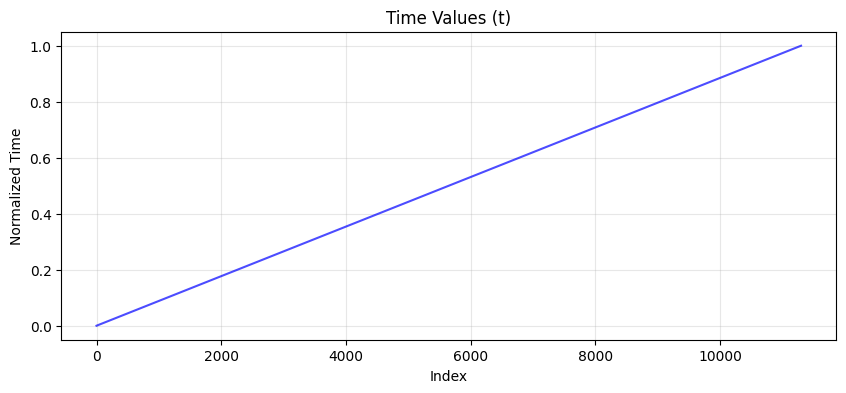

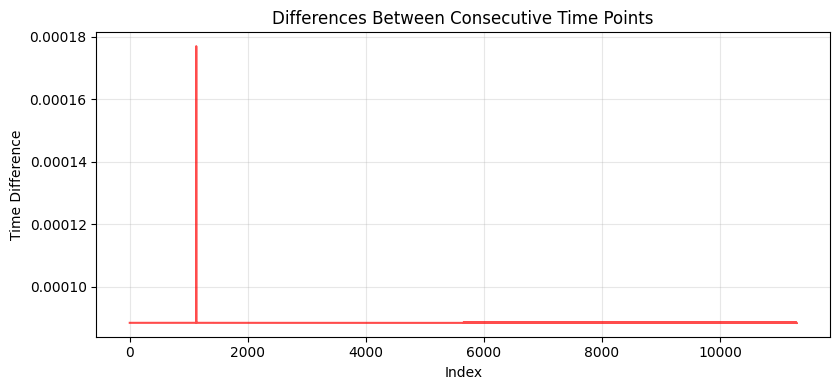

In [46]:
df = df_helechos_2018_2020.copy()

df.head()
print(t_seconds)
print(t)
# Check if t is monotonically increasing
is_monotonic = all(t[i] <= t[i+1] for i in range(len(t)-1))
print(f"Is t monotonically increasing? {is_monotonic}")

# Check the differences between consecutive elements
t_diff = t[1:] - t[:-1]
t_diff_log = torch.log(t_diff + 1e-8)  # log-transform to see relative changes
print(f"Minimum difference: {t_diff.min().item()}")
print(f"Maximum difference: {t_diff.max().item()}")
print(f"Mean difference: {t_diff.mean().item()}")

# Plot the time values to visualize
plt.figure(figsize=(10, 4))
plt.plot(t.numpy(), 'b-', alpha=0.7)
plt.title('Time Values (t)')
plt.ylabel('Normalized Time')
plt.xlabel('Index')
plt.grid(True, alpha=0.3)

# Plot the differences between consecutive time points
plt.figure(figsize=(8.5, 4))
plt.plot(t_diff.numpy(), 'r-', alpha=0.7)
plt.title('Differences Between Consecutive Time Points')
plt.ylabel('Time Difference')
plt.xlabel('Index')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Epoch    1/200  MSE: 1.065904
Epoch   25/200  MSE: 0.941203
Epoch   50/200  MSE: 0.912905
Epoch   75/200  MSE: 0.896348
Epoch  100/200  MSE: 0.882864
Epoch  125/200  MSE: 0.872919
Epoch  150/200  MSE: 0.865497
Epoch  175/200  MSE: 0.860026
Epoch  200/200  MSE: 0.854490


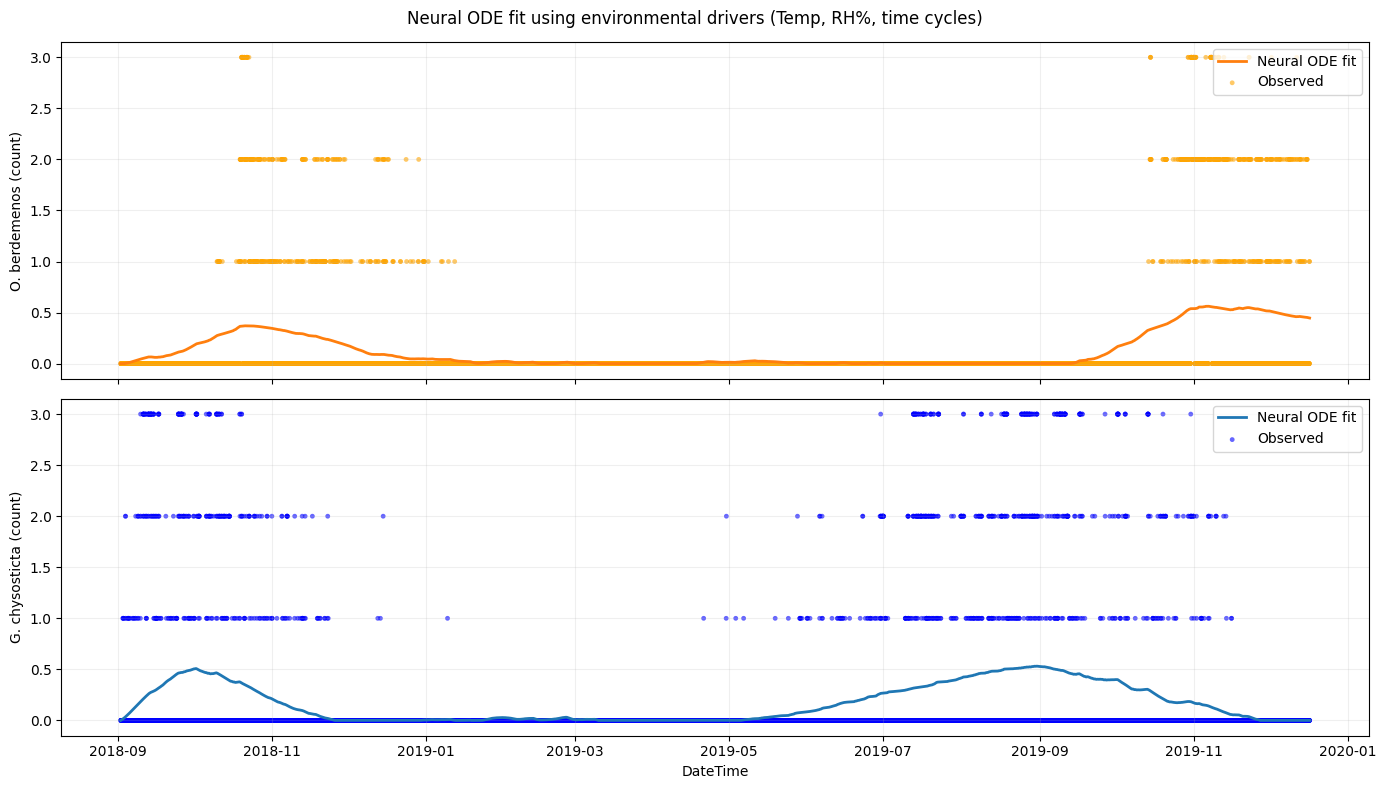

Final normalized MSE: 0.854298


In [47]:

# Targets (2D state): [O. berdemenos, G. chysosticta]
Y_np = df[[s1_col, s2_col]].values.astype("float32")
# Standardize targets
y_mean = torch.tensor(Y_np.mean(axis=0), dtype=torch.float32, device=device)
y_std = torch.tensor(Y_np.std(axis=0) + 1e-6, dtype=torch.float32, device=device)
Y = torch.tensor(Y_np, dtype=torch.float32, device=device)
Y_norm = (Y - y_mean) / y_std  # (N, 2)

# Exogenous features U(t): Temp, RH%, cyclical encodings for hour and day-of-year
# cyclical encodings to aid learning periodic patterns
hour = df["hour"].values.astype("float32")
dayofyear = df["DateTime"].dt.dayofyear.values.astype("float32")
temp = df["Temp"].values.astype("float32")
rh = df["RH%"].values.astype("float32")

hour_sin = np.sin(2 * np.pi * hour / 24.0)
hour_cos = np.cos(2 * np.pi * hour / 24.0)
day_sin = np.sin(2 * np.pi * dayofyear / 365.0)
day_cos = np.cos(2 * np.pi * dayofyear / 365.0)

U_np = np.stack([temp, rh, hour_sin, hour_cos, day_sin, day_cos], axis=1).astype("float32")

# Standardize features
U_mean = torch.tensor(U_np.mean(axis=0), dtype=torch.float32, device=device)
U_std = torch.tensor(U_np.std(axis=0) + 1e-6, dtype=torch.float32, device=device)
U = torch.tensor(U_np, dtype=torch.float32, device=device)
U_norm = (U - U_mean) / U_std  # (N, F)

# 3) Define Neural ODE: dy/dt = f_theta(t, y, u(t))
class ODEFunc(nn.Module):
    def __init__(self, U_aligned: torch.Tensor):
        super().__init__()
        self.U = U_aligned  # (N, F)
        self.N = U_aligned.shape[0]
        feat_dim = U_aligned.shape[1]
        state_dim = 2
        hidden = 64
        self.net = nn.Sequential(
            nn.Linear(state_dim + feat_dim + 2, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, state_dim),
        )

    def sample_u(self, t_scalar: torch.Tensor) -> torch.Tensor:
        # t_scalar in [0,1]; nearest-neighbor sampling of U(t)
        idx = torch.clamp(torch.round(t_scalar * (self.N - 1)).long(), 0, self.N - 1)
        u = self.U[idx]  # (F,)
        if u.dim() == 1:
            u = u.unsqueeze(0)  # (1, F)
        return u

    def forward(self, t_scalar: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        # y: (2,) or (B, 2)
        y_in = y if y.dim() > 1 else y.unsqueeze(0)  # (B, 2)
        u = self.sample_u(t_scalar)  # (B, F)
        t_enc = torch.stack(
            [torch.sin(2 * math.pi * t_scalar), torch.cos(2 * math.pi * t_scalar)]
        ).to(y_in.device).unsqueeze(0).expand(y_in.shape[0], -1)  # (B, 2)
        x = torch.cat([y_in, u, t_enc], dim=-1)  # (B, 2+F+2)
        dy = self.net(x)  # (B, 2)
        return dy if y.dim() > 1 else dy.squeeze(0)

func = ODEFunc(U_norm).to(device)

# 4) Train Neural ODE end-to-end by matching the full observed trajectory
y0 = Y_norm[0]              # initial state (2,)
dt = float(t[1].item() - t[0].item()) if len(t) > 1 else 1.0
optimizer = torch.optim.Adam(func.parameters(), lr=1e-2)
loss_fn = nn.MSELoss()

epochs = 200
for ep in range(1, epochs + 1):
    optimizer.zero_grad()
    # Integrate from y0 across all evaluation times t
    Yhat_norm = odeint(func, y0, t, method="rk4", options={"step_size": dt})  # (N, 2)
    loss = loss_fn(Yhat_norm, Y_norm)
    loss.backward()
    optimizer.step()
    if ep % 25 == 0 or ep == 1:
        print(f"Epoch {ep:4d}/{epochs}  MSE: {loss.item():.6f}")

# 5) Final prediction and inverse-transform to original scale
with torch.no_grad():
    Yhat_norm = odeint(func, y0, t, method="rk4", options={"step_size": dt})  # (N, 2)
Yhat = Yhat_norm * y_std + y_mean  # (N, 2)

# 6) Plot: Predicted vs Observed over time for both species
time_index = df["DateTime"].values
yhat_np = Yhat.detach().cpu().numpy()
yhat_np = np.clip(yhat_np, a_min=0.0, a_max=None)  # counts cannot be negative

fig_fit, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# O. berdemenos
axs[0].plot(time_index, yhat_np[:, 0], color="tab:orange", label="Neural ODE fit", linewidth=2)
axs[0].scatter(time_index, df[s1_col].values, s=12, alpha=0.6, color="orange", edgecolor="none", label="Observed")
axs[0].set_ylabel("O. berdemenos (count)")
axs[0].legend(loc="upper right")
axs[0].grid(True, alpha=0.2)

# G. chysosticta
axs[1].plot(time_index, yhat_np[:, 1], color="tab:blue", label="Neural ODE fit", linewidth=2)
axs[1].scatter(time_index, df[s2_col].values, s=12, alpha=0.6, color="blue", edgecolor="none", label="Observed")
axs[1].set_ylabel("G. chysosticta (count)")
axs[1].set_xlabel("DateTime")
axs[1].legend(loc="upper right")
axs[1].grid(True, alpha=0.2)

fig_fit.suptitle("Neural ODE fit using environmental drivers (Temp, RH%, time cycles)")
plt.tight_layout()
plt.show()

# 7) Report final training error
with torch.no_grad():
    final_mse = loss_fn(Yhat_norm, Y_norm).item()
print(f"Final normalized MSE: {final_mse:.6f}")


=== Training Neural ODE for target: Oreobates berdemenos (others exogenous) ===
Epoch    1/150  MSE: 1.030195
Epoch   50/150  MSE: 0.884392
Epoch  100/150  MSE: 0.859327
Epoch  150/150  MSE: 0.856506

=== Training Neural ODE for target: Gastrotheca chysosticta (others exogenous) ===
Epoch    1/150  MSE: 1.112001
Epoch   50/150  MSE: 0.939075
Epoch  100/150  MSE: 0.921699
Epoch  150/150  MSE: 0.902158

Summary (normalized MSE per species):
Oreobates berdemenos: 0.848522
Gastrotheca chysosticta: 0.901826


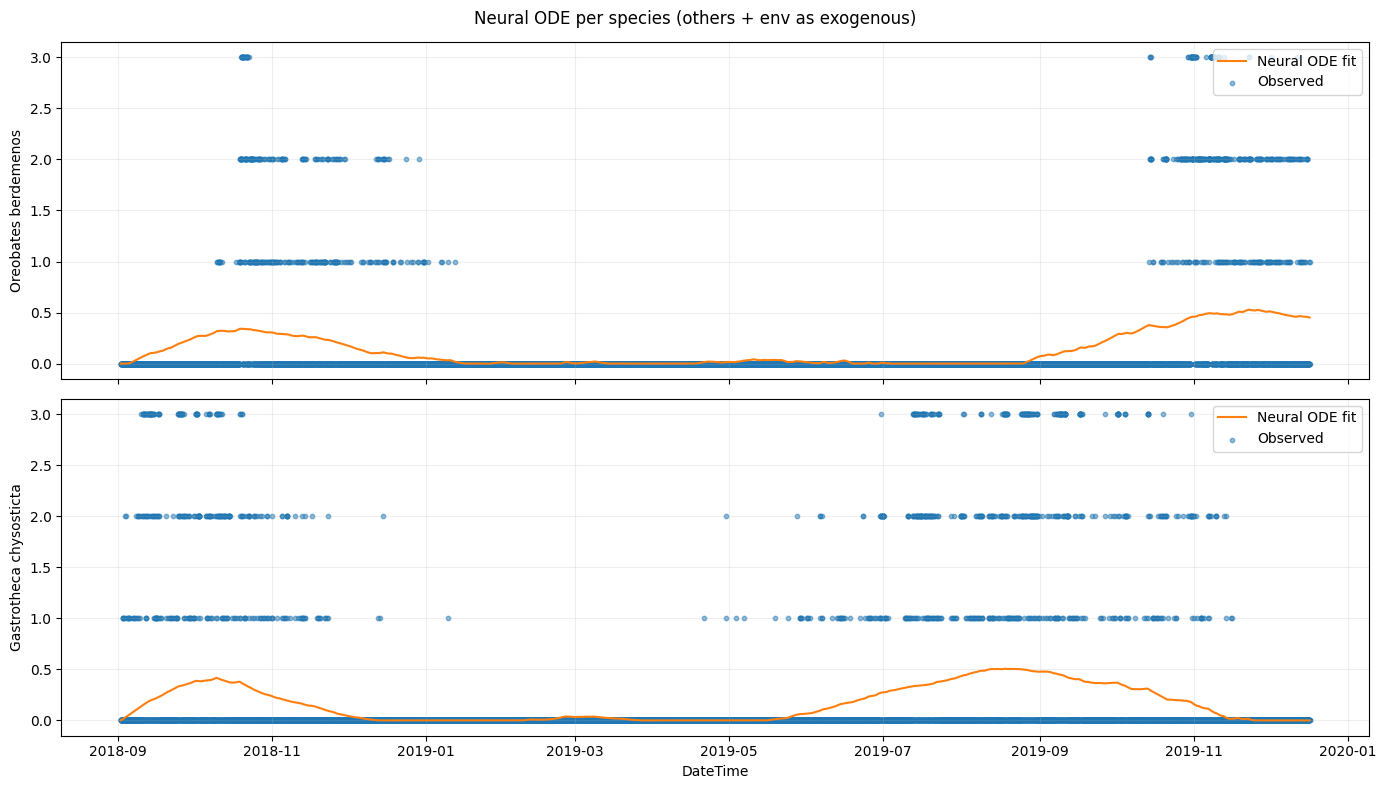

,DateTime,species,observed,predicted
0,2018-09-02 00:00:00,Oreobates berdemenos,0.0,7.450581e-09
1,2018-09-02 01:00:00,Oreobates berdemenos,0.0,0.000000e+00
2,2018-09-02 02:00:00,Oreobates berdemenos,0.0,0.000000e+00
3,2018-09-02 03:00:00,Oreobates berdemenos,0.0,0.000000e+00
4,2018-09-02 04:00:00,Oreobates berdemenos,0.0,0.000000e+00


In [49]:
# === Neural ODE per frog species; other species as exogenous features ===
import math, numpy as np, torch, torch.nn as nn
from torchdiffeq import odeint

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

# Base DataFrame
df_base = df_helechos_2018_2020.copy()

# Ensure DateTime
if 'DateTime' not in df_base.columns:
    df_base['DateTime'] = pd.to_datetime(df_base['Date']) + pd.to_timedelta(df_base['hour'], unit='h')

# Keep needed columns (extend species list if more present later)
env_cols = [c for c in ['Temp','RH%','hour'] if c in df_base.columns]
species_cols = [c for c in ['Oreobates berdemenos','Gastrotheca chysosticta'] if c in df_base.columns]

# Drop rows without DateTime
df_base = df_base[df_base['DateTime'].notna()].copy()

# Aggregate duplicates at DateTime (mean for counts/env; first for hour)
agg_map = {c: 'mean' for c in species_cols + [c for c in env_cols if c != 'hour']}
if 'hour' in df_base.columns:
    agg_map['hour'] = 'first'
df_base = df_base.groupby('DateTime', as_index=False).agg(agg_map).sort_values('DateTime').reset_index(drop=True)

# Interpolate environmental vars
for c in env_cols:
    df_base[c] = pd.to_numeric(df_base[c], errors='coerce').astype(float).interpolate().bfill().ffill()

# Interpolate species counts (leave zeros as zeros)
for sc in species_cols:
    df_base[sc] = pd.to_numeric(df_base[sc], errors='coerce').astype(float).interpolate().bfill().ffill()
    df_base[sc] = df_base[sc].clip(lower=0)

# Time normalization
t_seconds = (df_base['DateTime'] - df_base['DateTime'].iloc[0]).dt.total_seconds().values.astype('float64')
# Enforce strictly increasing
eps = 1e-3
for i in range(1, len(t_seconds)):
    if t_seconds[i] <= t_seconds[i-1]:
        t_seconds[i] = t_seconds[i-1] + eps
t_norm = (t_seconds - t_seconds.min()) / (t_seconds.max() - t_seconds.min())
t_all = torch.tensor(t_norm, dtype=torch.float32, device=device)

# Pre-compute time encodings
doy = df_base['DateTime'].dt.dayofyear.values.astype('float32')
hour = df_base['hour'].values.astype('float32') if 'hour' in df_base.columns else np.zeros(len(df_base), dtype='float32')
time_feats_np = np.stack([
    np.sin(2*np.pi*hour/24.0),
    np.cos(2*np.pi*hour/24.0),
    np.sin(2*np.pi*doy/365.0),
    np.cos(2*np.pi*doy/365.0)
], axis=1).astype('float32')

# Environmental features
env_arrays = []
if 'Temp' in df_base.columns: env_arrays.append(df_base['Temp'].values.astype('float32'))
if 'RH%' in df_base.columns: env_arrays.append(df_base['RH%'].values.astype('float32'))
if not env_arrays:
    env_stack = np.zeros((len(df_base),0), dtype='float32')
else:
    env_stack = np.stack(env_arrays, axis=1).astype('float32')

results = {}
predictions_collect = []

class ODEFunc1D(nn.Module):
    def __init__(self, U_aligned: torch.Tensor):
        super().__init__()
        self.U = U_aligned
        self.N, feat_dim = U_aligned.shape
        hidden = 64
        self.net = nn.Sequential(
            nn.Linear(1 + feat_dim + 2, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1),
        )
    def sample_u(self, t_scalar: torch.Tensor):
        idx = torch.clamp(torch.round(t_scalar * (self.N - 1)).long(), 0, self.N - 1)
        u = self.U[idx]
        if u.dim() == 1: u = u.unsqueeze(0)
        return u
    def forward(self, t_scalar, y):
        y_in = y if y.dim() > 1 else y.unsqueeze(0)
        u = self.sample_u(t_scalar)
        t_enc = torch.stack([torch.sin(2*math.pi*t_scalar), torch.cos(2*math.pi*t_scalar)]
                            ).to(y_in.device).unsqueeze(0).expand(y_in.shape[0], -1)
        x = torch.cat([y_in, u, t_enc], dim=-1)
        return self.net(x) if y.dim() > 1 else self.net(x).squeeze(0)

for target in species_cols:
    print(f"\n=== Training Neural ODE for target: {target} (others exogenous) ===")
    # Build feature matrix: env + time cyc + other species (excluding target)
    other_species = [s for s in species_cols if s != target]
    other_mat = df_base[other_species].values.astype('float32') if other_species else np.zeros((len(df_base),0),'float32')
    U_np = np.concatenate([env_stack, time_feats_np, other_mat], axis=1).astype('float32')
    # Standardize features
    U_mean = U_np.mean(axis=0, keepdims=True)
    U_std = U_np.std(axis=0, keepdims=True) + 1e-6
    U_norm_np = (U_np - U_mean) / U_std
    U_tensor = torch.tensor(U_norm_np, dtype=torch.float32, device=device)

    # Target series
    y_np = df_base[target].values.astype('float32')
    y_mean = y_np.mean()
    y_std = y_np.std() + 1e-6
    y_norm = (y_np - y_mean) / y_std
    Y_tensor = torch.tensor(y_norm, dtype=torch.float32, device=device)

    func = ODEFunc1D(U_tensor).to(device)
    y0 = Y_tensor[0:1]  # shape (1,)
    dt = float((t_all[1]-t_all[0]).item()) if len(t_all) > 1 else 1.0

    optimizer = torch.optim.Adam(func.parameters(), lr=5e-3)
    loss_fn = nn.MSELoss()
    epochs = 150

    for ep in range(1, epochs+1):
        optimizer.zero_grad()
        Yhat_norm = odeint(func, y0, t_all, method="rk4", options={"step_size": dt}).squeeze(-1)  # (N,)
        loss = loss_fn(Yhat_norm, Y_tensor)
        if torch.isnan(loss):
            print("NaN loss encountered. Stopping.")
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(func.parameters(), 5.0)
        optimizer.step()
        if ep % 50 == 0 or ep == 1:
            print(f"Epoch {ep:4d}/{epochs}  MSE: {loss.item():.6f}")

    with torch.no_grad():
        Yhat_norm = odeint(func, y0, t_all, method="rk4", options={"step_size": dt}).squeeze(-1)
        final_mse = loss_fn(Yhat_norm, Y_tensor).item()
        Yhat = (Yhat_norm.cpu().numpy() * y_std) + y_mean
        Yhat = np.clip(Yhat, 0, None)

    results[target] = {
        "mse_norm": final_mse,
        "y_mean": y_mean,
        "y_std": y_std,
        "U_mean": U_mean,
        "U_std": U_std,
        "pred": Yhat,
        "true": y_np
    }

    # Collect predictions for combined DataFrame
    predictions_collect.append(pd.DataFrame({
        'DateTime': df_base['DateTime'],
        'species': target,
        'observed': y_np,
        'predicted': Yhat
    }))

# Combined predictions DataFrame
predictions_df = pd.concat(predictions_collect, ignore_index=True)

print("\nSummary (normalized MSE per species):")
for k,v in results.items():
    print(f"{k}: {v['mse_norm']:.6f}")

# Plot per-species fits
n = len(species_cols)
fig, axs = plt.subplots(n, 1, figsize=(14, 4*n), sharex=True)
if n == 1: axs = [axs]
time_index = df_base['DateTime'].values
for ax, sp in zip(axs, species_cols):
    ax.plot(time_index, results[sp]['pred'], label='Neural ODE fit', color='tab:orange')
    ax.scatter(time_index, results[sp]['true'], s=10, alpha=0.5, color='tab:blue', label='Observed')
    ax.set_ylabel(sp)
    ax.grid(alpha=0.2)
    ax.legend(loc='upper right')
axs[-1].set_xlabel("DateTime")
fig.suptitle("Neural ODE per species (others + env as exogenous)")
plt.tight_layout()
plt.show()

# predictions_df now holds long-format results
predictions_df.head()

In [50]:
df_base = df_helechos_2018_2020.copy()
df_base.head()

,Date,Month,Day,hour,Temp,RH%,Gastrotheca chysosticta,Oreobates berdemenos,DateTime
0,2018-09-02,9,245,0,4.553,100.0,0,0,2018-09-02 00:00:00
1,2018-09-02,9,245,1,4.051,100.0,0,0,2018-09-02 01:00:00
2,2018-09-02,9,245,2,4.553,100.0,0,0,2018-09-02 02:00:00
3,2018-09-02,9,245,3,3.550,100.0,0,0,2018-09-02 03:00:00
4,2018-09-02,9,245,4,3.048,100.0,0,0,2018-09-02 04:00:00


In [ ]:
# Save the current df_helechos to CSV
output_csv = f"{PT_drive}/df_helechos_clean.csv"
df_helechos_2018_2020.to_csv(output_csv, index=False)
print(f"Saved df_helechos to {output_csv} (rows={len(df_helechos_2018_2020)}, cols={df_helechos_2018_2020.shape[1]})")

Saved df_helechos to /Users/ash/Library/CloudStorage/OneDrive-Nexus365/PHD/arunan/Martin_google_drive/df_helechos_clean.csv (rows=16799, cols=8)


In [66]:
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchdiffeq import odeint

# -------------------------------
# Config: update these to match your CSV
# -------------------------------
CSV_PATH     = "frog_calls.csv"   # path to your data
DATETIME_COL = "DateTime"        # name of the DateTime column
TEMP_COL     = "Temp"
HUM_COL      = "RH%"
A_COL        = "Gastrotheca chysosticta"
B_COL        = "Oreobates berdemenos"

# Optional: set your local timezone for "day" boundaries (e.g., "America/New_York")
# If your timestamp column is already tz-aware and correct, you can leave this None.
LOCAL_TZ = None  # e.g., "America/Chicago"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# -------------------------------
# Utility: Zero-Order Hold for u(t)
# -------------------------------
class ZeroOrderHold(nn.Module):
    """
    Zero-order hold u(t): constant between sample times t_i.
    """
    def __init__(self, t_grid: torch.Tensor, u_values: torch.Tensor):
        super().__init__()
        assert t_grid.ndim == 1
        assert u_values.ndim == 2 and u_values.size(0) == t_grid.size(0)
        self.register_buffer("t_grid", t_grid)     # (T,)
        self.register_buffer("u_values", u_values) # (T, p)

    def forward(self, t: torch.Tensor) -> torch.Tensor:
        # t is scalar tensor (possibly with grad). We do bucketize on detached copy.
        tt = t.detach().reshape(1)
        idx = torch.bucketize(tt, self.t_grid) - 1  # last index with t_grid[idx] <= t
        idx = torch.clamp(idx, 0, self.t_grid.numel() - 1)
        return self.u_values[idx.item()]            # (p,)

# -------------------------------
# Neural ODE vector field
# -------------------------------
class InteractionODE(nn.Module):
    """
    dz/dt = z @ Wx^T + u(t) @ Wu^T + b  [+ optional residual MLP]
    - Wx (2x2) captures self- and cross-species interactions.
      Diagonals are constrained negative (damping) via -softplus.
    - Wu (2xp) captures effects of exogenous inputs (hour sin/cos, temp_z, hum_z).
    """
    def __init__(self, n_u: int, residual=False, hidden=16):
        super().__init__()
        self.n_u = n_u

        self._Wx_free = nn.Parameter(torch.zeros(2, 2))
        self._Wx_diag_raw = nn.Parameter(torch.tensor([0.1, 0.1]))  # negative after softplus
        self.Wu = nn.Parameter(torch.zeros(2, n_u))
        self.b  = nn.Parameter(torch.zeros(2))

        self.use_residual = residual
        if residual:
            self.res = nn.Sequential(
                nn.Linear(2 + n_u, hidden),
                nn.Tanh(),
                nn.Linear(hidden, 2),
            )
            self.res_scale = nn.Parameter(torch.tensor(0.0))

        self.u_fun = None
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self._Wx_free)
        with torch.no_grad():
            self._Wx_free[0, 0] = 0.0
            self._Wx_free[1, 1] = 0.0
        nn.init.xavier_uniform_(self.Wu)
        nn.init.zeros_(self.b)

    def set_u(self, u_fun: ZeroOrderHold):
        self.u_fun = u_fun

    def Wx(self):
        Wx = self._Wx_free.clone()
        diag = -F.softplus(self._Wx_diag_raw)  # strictly negative
        Wx[0, 0] = diag[0]
        Wx[1, 1] = diag[1]
        return Wx

    def forward(self, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        u_t = self.u_fun(t)  # (p,)
        Wx = self.Wx()
        dz = z @ Wx.T + u_t @ self.Wu.T + self.b  # (2,)
        if self.use_residual:
            dz = dz + self.res_scale * self.res(torch.cat([z, u_t], dim=-1))
        return dz

# -------------------------------
# Observation model: Ordered logistic (0..3)
# -------------------------------
class OrderedLogistic(nn.Module):
    """
    Cumulative link with 3 cutpoints (for 4 categories).
    P(Y<=k | y) = sigmoid(c_k - y), k=0..2
    Enforces c_0 < c_1 < c_2 via cumulative softplus.
    """
    def __init__(self, n_cuts=3):
        super().__init__()
        self._deltas = nn.Parameter(torch.ones(n_cuts))
        self._offset = nn.Parameter(torch.tensor(0.0))

    def cutpoints(self) -> torch.Tensor:
        return torch.cumsum(F.softplus(self._deltas), dim=0) + self._offset  # (3,)

    def nll(self, y_latent: torch.Tensor, y_cat: torch.Tensor) -> torch.Tensor:
        c = self.cutpoints()
        s = torch.sigmoid
        p0 = s(c[0] - y_latent)
        p1 = s(c[1] - y_latent) - s(c[0] - y_latent)
        p2 = s(c[2] - y_latent) - s(c[1] - y_latent)
        p3 = 1.0 - s(c[2] - y_latent)
        P = torch.stack([p0, p1, p2, p3], dim=-1).clamp_min(1e-8)  # (T,4)
        chosen = P.gather(1, y_cat.long().unsqueeze(1)).squeeze(1)
        return -torch.log(chosen).mean()

# -------------------------------
# Full model wrapper
# -------------------------------
class FrogNODEModel(nn.Module):
    def __init__(self, n_u: int, n_days: int, residual=False):
        super().__init__()
        self.odefunc = InteractionODE(n_u=n_u, residual=residual)
        self.obs_A   = OrderedLogistic(n_cuts=3)
        self.obs_B   = OrderedLogistic(n_cuts=3)
        self.z0_table = nn.Parameter(torch.zeros(n_days, 2))  # per-day initial states

    def integrate_day(self, seq, day_index: int):
        self.odefunc.set_u(ZeroOrderHold(seq["t"], seq["u"]))
        z0 = self.z0_table[day_index]  # (2,)
        zt = odeint(self.odefunc, z0, seq["t"], method="dopri5", rtol=1e-5, atol=1e-7)  # (T,2)
        yA_latent = zt[:, 0]
        yB_latent = zt[:, 1]
        nllA = self.obs_A.nll(yA_latent, seq["yA"])
        nllB = self.obs_B.nll(yB_latent, seq["yB"])
        return nllA, nllB, zt

    def forward(self, sequences):
        total_nll = 0.0
        for seq in sequences:
            nllA, nllB, _ = self.integrate_day(seq, seq["day_index"])
            total_nll = total_nll + nllA + nllB
        return total_nll

    @property
    def Wx(self):
        return self.odefunc.Wx().detach().cpu().numpy()

    @property
    def Wu(self):
        return self.odefunc.Wu.detach().cpu().numpy()

# -------------------------------
# NEW: Load/prepare using a DateTime column
# -------------------------------
def load_and_prepare_from_datetime(
    csv_path,
    datetime_col=DATETIME_COL,
    local_tz: str | None = LOCAL_TZ
):
    """
    Expects columns:
      datetime_col (timestamp), temperature, humidity, frog_a, frog_b
    - Derives per-day sequences by flooring timestamp to local midnight.
    - Builds time axis t as hours since local midnight (can be fractional).
    """
    df = df_helechos_2018_2020.copy()

    # Parse datetime
    if datetime_col not in df.columns:
        raise ValueError(f"Missing required DateTime column '{datetime_col}' in {csv_path}")
    df[datetime_col] = pd.to_datetime(df[datetime_col], errors="coerce")
    df = df.dropna(subset=[datetime_col, TEMP_COL, HUM_COL, A_COL, B_COL]).copy()

    # Handle timezone:
    ts = df[datetime_col]
    if ts.dt.tz is None:
        # Naive datetimes: optionally localize to a timezone
        if local_tz is not None:
            ts = ts.dt.tz_localize(local_tz)
    else:
        # Aware datetimes: optionally convert
        if local_tz is not None:
            ts = ts.dt.tz_convert(local_tz)
    df["_ts"] = ts

    # Define day boundary and within-day elapsed hours
    df["_day_start"] = df["_ts"].dt.floor("D")  # timezone-aware midnight
    # elapsed time since local midnight in hours (fractional)
    df["_t_rel_h"] = (df["_ts"] - df["_day_start"]) / pd.Timedelta(hours=1)

    # Cyclical encoding for time-of-day using fractional hours
    df["hour_sin"] = np.sin(2.0 * np.pi * df["_t_rel_h"].values / 24.0)
    df["hour_cos"] = np.cos(2.0 * np.pi * df["_t_rel_h"].values / 24.0)

    # Standardize continuous variables
    cont_cols = [TEMP_COL, HUM_COL]
    cont_means = df[cont_cols].mean()
    cont_stds  = df[cont_cols].std().replace(0.0, 1.0)

    for c in cont_cols:
        df[c + "_z"] = (df[c] - cont_means[c]) / cont_stds[c]

    feature_cols = ["hour_sin", "hour_cos", TEMP_COL + "_z", HUM_COL + "_z"]

    # Build per-day sequences (>=2 unique time points)
    sequences = []
    # Stable, reproducible day indexing
    unique_days = (
        df[["_day_start"]].drop_duplicates().sort_values("_day_start").reset_index(drop=True)
    )
    day2idx = {row["_day_start"]: i for i, row in unique_days.iterrows()}

    for day_ts, g in df.groupby("_day_start"):
        g = g.sort_values("_t_rel_h")
        # Drop duplicate times (odeint wants strictly non-decreasing; equal times add no information)
        g = g.drop_duplicates(subset="_t_rel_h", keep="first")
        if len(g) < 2:
            continue

        t = torch.tensor(g["_t_rel_h"].values.astype(np.float32), device=device)  # hours since midnight
        u = torch.tensor(g[feature_cols].values.astype(np.float32), device=device)  # (T, p)
        yA = torch.tensor(g[A_COL].values.astype(np.int64), device=device)
        yB = torch.tensor(g[B_COL].values.astype(np.int64), device=device)

        sequences.append(
            {
                "day_index": int(day2idx[day_ts]),
                "day_start": pd.Timestamp(day_ts),  # for reference/inspection
                "t": t,
                "u": u,
                "yA": yA,
                "yB": yB,
            }
        )

    meta = {
        "feature_cols": feature_cols,
        "cont_means": cont_means.to_dict(),
        "cont_stds": cont_stds.to_dict(),
        "day2idx": {str(k): v for k, v in day2idx.items()},  # stringified keys for readability
        "timezone": local_tz if local_tz is not None else ("from data" if df["_ts"].dt.tz is not None else "naive"),
    }
    return sequences, meta

# -------------------------------
# Training and reporting
# -------------------------------
def train_model(sequences, meta, epochs=1200, lr=1e-2, l1_lambda=1e-4, residual=False):
    feature_cols = meta["feature_cols"]
    n_u = len(feature_cols)
    # number of distinct days in z0 table
    n_days = 1 + max(seq["day_index"] for seq in sequences)

    model = FrogNODEModel(n_u=n_u, n_days=n_days, residual=residual).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    for ep in range(1, epochs + 1):
        opt.zero_grad()
        total_nll = 0.0
        for seq in sequences:
            nllA, nllB, _ = model.integrate_day(seq, seq["day_index"])
            total_nll = total_nll + nllA + nllB

        # L1 sparsity specifically on interpretable couplings
        l1 = model.odefunc._Wx_free.abs().sum() + model.odefunc.Wu.abs().sum()
        loss = total_nll + l1_lambda * l1

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        opt.step()

        if ep % 100 == 0 or ep <= 10:
            print(f"[{ep:04d}] loss={loss.item():.4f}  (nll={total_nll.item():.4f}, l1={l1.item():.4f})")

    return model

def summarize_interactions(model, meta):
    feature_cols = meta["feature_cols"]
    Wx = model.Wx  # 2x2
    Wu = model.Wu  # 2xp

    print("\n=== Species ↔ Species interaction matrix Wx (rows: [A_dot, B_dot], cols: [A, B]) ===")
    print(pd.DataFrame(Wx, index=["A_dot", "B_dot"], columns=["A", "B"]).round(4))

    print("\nInterpretation:")
    print(f"  Wx[0,1] (B → A) = {Wx[0,1]:+.4f}  | positive: B promotes A; negative: B inhibits A")
    print(f"  Wx[1,0] (A → B) = {Wx[1,0]:+.4f}  | positive: A promotes B; negative: A inhibits B")
    print(f"  Wx[0,0] (A self) = {Wx[0,0]:+.4f}  | typically <0 (damping)")
    print(f"  Wx[1,1] (B self) = {Wx[1,1]:+.4f}  | typically <0 (damping)")

    df_Wu = pd.DataFrame(Wu, index=["A_dot", "B_dot"], columns=feature_cols).round(4)
    print("\n=== Environment → Species matrix Wu (rows: [A_dot, B_dot]) ===")
    print(df_Wu)

    # Summarize diurnal effect amplitude/phase
    if "hour_sin" in feature_cols and "hour_cos" in feature_cols:
        i_sin = feature_cols.index("hour_sin")
        i_cos = feature_cols.index("hour_cos")
        for k, sp in enumerate(["A", "B"]):
            w_sin = Wu[k, i_sin]
            w_cos = Wu[k, i_cos]
            amp   = math.sqrt(w_sin**2 + w_cos**2)
            phase = math.atan2(w_sin, w_cos)  # radians
            peak_hour = (phase / (2 * math.pi)) * 24.0
            print(f"\n{sp}: diurnal effect amplitude on dz/dt = {amp:.4f}, peak hour (phase) ≈ {peak_hour:.2f}h (mod 24)")

    print("\nNotes:")
    print("- Wu coefficients are per 1 standard deviation of each standardized variable (temperature_z, humidity_z).")
    print("- Signs/magnitudes are on the derivative scale (effect on rate of change of latent call intensity).")
    print("- For nonlinearity, set residual=True in train_model; linear terms remain interpretable.")

# -------------------------------
# Run training
# -------------------------------
if __name__ == "__main__":
    sequences, meta = load_and_prepare_from_datetime(
        CSV_PATH,
        datetime_col=DATETIME_COL,
        local_tz=LOCAL_TZ
    )
    if len(sequences) == 0:
        raise RuntimeError("No day sequences with at least 2 time points were found. Check your data / DateTime column.")

    print(f"Loaded {len(sequences)} day-sequences; features = {meta['feature_cols']}; timezone = {meta['timezone']}")
    model = train_model(
        sequences,
        meta,
        epochs=1200,     # increase if needed
        lr=1e-2,
        l1_lambda=1e-4,  # sparsity on Wx/Wu
        residual=False   # set True to allow a small nonlinear residual
    )
    summarize_interactions(model, meta)


Loaded 471 day-sequences; features = ['hour_sin', 'hour_cos', 'Temp_z', 'RH%_z']; timezone = naive
[0001] loss=541.0964  (nll=541.0959, l1=5.4700)
[0002] loss=528.7541  (nll=528.7535, l1=5.4500)
[0003] loss=517.3141  (nll=517.3135, l1=5.4300)
[0004] loss=506.6902  (nll=506.6897, l1=5.4099)
[0005] loss=496.8133  (nll=496.8128, l1=5.3896)
[0006] loss=487.6419  (nll=487.6413, l1=5.3692)
[0007] loss=479.0820  (nll=479.0815, l1=5.3485)
[0008] loss=471.1026  (nll=471.1021, l1=5.3274)
[0009] loss=463.6502  (nll=463.6497, l1=5.3058)
[0010] loss=456.6653  (nll=456.6648, l1=5.2836)


KeyboardInterrupt: 

In [68]:
summarize_interactions(model, meta)

NameError: name 'model' is not defined